In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#make a copy of this folder to your own drive, or change the data dir path
tables_dir = '/content/drive/My Drive/core_tables_clustered'
wheat_path = '/wheat'
maize_path = '/maize'
rice_path = '/rice'
soybean_path = '/soybean'
path_suffix = '.csv'
crop = 'wheat'
with open(tables_dir+ "/" + crop.lower() +path_suffix, 'r') as f:
  df = pd.read_csv(f)


In [ ]:
sample_years = list(range(1981, 2015))
yield_years = ['yield_' + str(year) for year in sample_years]

#check if all yield are 0, discard those
df_yields = df[yield_years]
df = df.loc[(df_yields != 0).any(axis=1), :]

df.shape

(2511, 72)

In [ ]:
sample_years = list(range(1981, 2015))
yield_years = ['yield_' + str(year) for year in sample_years]

#check if all yield are 0, discard those
df_yields = df[yield_years]
df = df.loc[(df_yields != 0).any(axis=1), :]

df.shape

average_temp_years = ['average_temp_' + str(year) for year in sample_years] + ['state']
yield_years = yield_years + ['state']
X = df[average_temp_years]
y = df[yield_years]


#Group temp and yield with the same state
states = list(set(df['state'].tolist()))
state_X, state_Y = defaultdict(list), defaultdict(list)
for state in states:
  df_state_X = df[average_temp_years]
  df_state_Y = df[yield_years]
  state_X[state] = df_state_X[df_state_X['state'] == state]
  state_Y[state] = df_state_Y[df_state_Y['state'] == state]
  #reshape the data points we have for each state
  state_X[state] = np.array(state_X[state].iloc[:, :-1]).flatten().reshape((state_X[state].shape[0]*(state_X[state].shape[1]-1), 1))
  state_Y[state] = np.array(state_Y[state].iloc[:, :-1]).flatten().reshape((state_Y[state].shape[0]*(state_Y[state].shape[1]-1), 1))


X = np.array(X.iloc[:, :-1]).flatten()
y = np.array(y.iloc[:, :-1]).flatten()



nonzero_indices = np.nonzero(y)
X = X[nonzero_indices]
y = y[nonzero_indices]
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)



In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

reg = linear_model.LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('Coefficients: \n', reg.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[-0.01310487]]
Mean squared error: 6.89
Coefficient of determination: 0.00


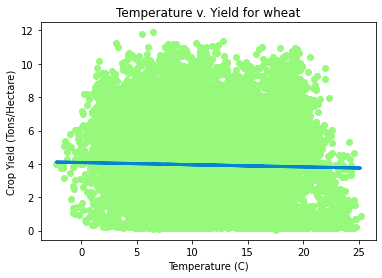

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_test, y_pred, color='xkcd:cerulean', linewidth=3)
plt.scatter(X_test, y_test, color='xkcd:light green')
plt.xlabel('Temperature (C)')
plt.ylabel('Crop Yield (Tons/Hectare)')
plt.title("Temperature v. Yield for " + crop)

plt.show()

In [ ]:
# get residuals for training data and testing data (residuals = difference in real and predicted values)
predicted_x_train = reg.predict(X_train)
predicted_x_test = reg.predict(X_test)

x_train_res = X_train - predicted_x_train
x_test_res = X_test - predicted_x_test

t_statistic, p_value = stats.ttest_1samp(x_test_res, 0)

print("Mean of test residuals = " + str(np.average(x_test_res)))

print("Test Stat = " + str(t_statistic))
print("Test P Val = " + str(p_value))

t_stat_compare, p_val_compare = stats.ttest_ind(x_train_res, x_test_res)

print("Compare Stat = " + str(t_stat_compare))
print("Compare P Val = " + str(p_val_compare))

Mean of test residuals = 7.3773619941402915
Test Stat = [181.19819663]
Test P Val = [0.]
Compare Stat = [1.2943266]
Compare P Val = [0.1955563]


In [ ]:
r_squared_list = []
best_state = None
best_r_squared = float('-inf')
worst_r_squared = float('inf')
worst_state = None
X_list = []
y_pred_list = []
for state in states:
  X = state_X[state]
  y = state_Y[state]

  nonzero_indices = np.nonzero(y)
  X = X[nonzero_indices]
  y = y[nonzero_indices]
  X = X.reshape(-1, 1)
  y = y.reshape(-1, 1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
  reg.fit(X_train, y_train)
  y_pred = reg.predict(X_test)


  # temp_df = pd.Dataframe()

  # X_list.append(X_test)
  # y_pred_list.append(y_pred)

  r_squared = r2_score(y_test, y_pred)
  r_squared_list.append(r_squared)
  if r_squared > best_r_squared:
    best_r_squared = r_squared
    best_state = state
    best_X = X_test
    best_y = y_pred
  if r_squared < worst_r_squared:
    worst_r_squared = r_squared
    worst_state = state
    worst_X = X_test
    worst_y = y_pred

print("Best State: {}, Best R-squared: {}, Average R-squared: {}".format(best_state, best_r_squared, np.average(r_squared_list)))
# all_r_squareds.append(r_squared_list)

Best State: Mississippi, Best R-squared: 0.3556735567930118, Average R-squared: 0.09330719708852019


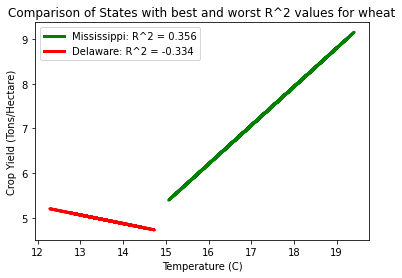

In [ ]:
import matplotlib.pyplot as plt


plt.plot(best_X, best_y, color='green', linewidth=3, label=best_state + ": R^2 = %.3f" %best_r_squared)
plt.plot(worst_X, worst_y, color='red', linewidth=3, label=worst_state + ": R^2 = %.3f" %worst_r_squared)
plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('Crop Yield (Tons/Hectare)')
plt.title("Comparison of States with best and worst R^2 values for " + crop)
plt.show()

In [ ]:
from collections import defaultdict
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

crops = ['maize', 'rice', 'soybean', 'wheat']
all_r_squareds = []
for crop in crops:
  print(crop)
  with open(tables_dir+ "/" + crop.lower() +path_suffix, 'r') as f:
    df = pd.read_csv(f)

  sample_years = list(range(1981, 2015))
  yield_years = ['yield_' + str(year) for year in sample_years]

  #check if all yield are 0, discard those
  df_yields = df[yield_years]
  df = df.loc[(df_yields != 0).any(axis=1), :]

  average_temp_years = ['average_temp_' + str(year) for year in sample_years] + ['state']
  yield_years = yield_years + ['state']
  X = df[average_temp_years]
  y = df[yield_years]
  
  #Group temp and yield with the same state
  states = list(set(df['state'].tolist()))
  state_X, state_Y = defaultdict(list), defaultdict(list)
  for state in states:
    df_state_X = df[average_temp_years]
    df_state_Y = df[yield_years]
    state_X[state] = df_state_X[df_state_X['state'] == state]
    state_Y[state] = df_state_Y[df_state_Y['state'] == state]
    #reshape the data points we have for each state
    state_X[state] = np.array(state_X[state].iloc[:, :-1]).flatten().reshape((state_X[state].shape[0]*(state_X[state].shape[1]-1), 1))
    state_Y[state] = np.array(state_Y[state].iloc[:, :-1]).flatten().reshape((state_Y[state].shape[0]*(state_Y[state].shape[1]-1), 1))


  X = np.array(X.iloc[:, :-1]).flatten()
  y = np.array(y.iloc[:, :-1]).flatten()



  nonzero_indices = np.nonzero(y)
  X = X[nonzero_indices]
  y = y[nonzero_indices]
  X = X.reshape(-1, 1)
  y = y.reshape(-1, 1)

  r_squared_list = []
  best_state = None
  best_r_squared = float('-inf')
  worst_r_squared = float('inf')
  worst_state = None
  X_list = []
  y_pred_list = []
  for state in states:
    X = state_X[state]
    y = state_Y[state]

    nonzero_indices = np.nonzero(y)
    X = X[nonzero_indices]
    y = y[nonzero_indices]
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)


    
    d = {'temp': X.flatten(), 'yield': y.flatten()}
    temp_df = pd.DataFrame(data=d, index=[i for i in range(len(X))])

    temp_df.loc[-1] = [reg.coef_[0][0], reg.intercept_[0]]
    temp_df.index = temp_df.index + 1
    temp_df = temp_df.sort_index()

    

    r_squared = r2_score(y_test, y_pred)
    r_squared_list.append(r_squared)

    temp_df.loc[-1] = [r_squared, len(X)]
    temp_df.index = temp_df.index + 1
    temp_df = temp_df.sort_index()
    file_path = state + "_" + crop + '_data.csv'
    temp_df.to_csv("drive/My Drive/webapp_data/" + state + "_" + crop + '_data.csv')

    if r_squared > best_r_squared:
      best_r_squared = r_squared
      best_state = state
      best_X = X_test
      best_y = y_pred
    if r_squared < worst_r_squared:
      worst_r_squared = r_squared
      worst_state = state
      worst_X = X_test
      worst_y = y_pred

  print("Best State: {}, Best R-squared: {}, Average R-squared: {}".format(best_state, best_r_squared, np.average(r_squared_list)))
  all_r_squareds.append(r_squared_list)


maize
Best State: New Jersey, Best R-squared: 0.3906125934337882, Average R-squared: 0.0777112006700363
rice
Best State: Texas, Best R-squared: 0.2863447669330944, Average R-squared: 0.04156069502412904
soybean
Best State: New Jersey, Best R-squared: 0.4434732560354995, Average R-squared: 0.061726704602733676
wheat
Best State: Mississippi, Best R-squared: 0.3556735567930118, Average R-squared: 0.09330719708852019


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


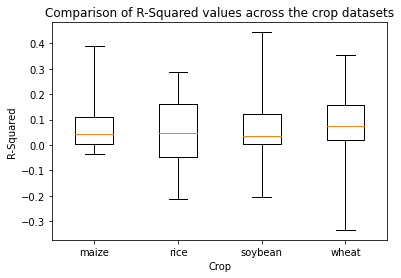

In [ ]:
import matplotlib.pyplot as plt


plt.boxplot(all_r_squareds, whis=(0, 100), labels=crops, showfliers=False)
plt.xlabel("Crop")
plt.ylabel("R-Squared")

plt.title("Comparison of R-Squared values across the crop datasets")
plt.show()